# 4 Modeling

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Modeling](#4_Modeling)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
    * [4.2.1 Recap of Data Science Problem](#4.2.1_Recap_of_Data_Science_Problem)
    * [4.2.2 Introduction To Notebook](#4.2.2_Introduction_To_Notebook)
  * [4.3 Objectives](#4.3_Objectives)
  * [4.4 Imports](#4.4_Imports)
  * [4.5 Load Data](#4.5_Load_Data)
  * [3.6 Filling in missing values with moving average](#3.6_Filling_in_missing_values_with_moving_average)
  * [3.7 Merge building data with processed weather data](#3.7_Merge_building_data_with_processed_weather_data)
  * [3.8 Add additional features](#3.8_Add_additional_features)
  * [3.9 Set aside validation data](#3.9_Set_aside_validation_data)
  * [3.10 Split data into training and testing data](#3.10_Split_data_into_training_and_testing_data)
    * [3.10.1 Subsample the data for linear regression and random forest models](#3.10.1_Subsample_the_data_for_linear_regression_and_random_forest_models)

## 4.2 Introduction<a id='4.2_Introduction'></a>

### 4.2.1 Recap of Data Science Problem<a id='4.2.1_Recap_of_Data_Science_Problem'></a>

### 4.2.2 Introduction to Notebook<a id='4.2.2_Introduction_to_Notebook'></a>

## 4.3 Objectives<a id='4.3_Objectives'></a>

The objective of this notebook is to train the following models:

* A dummy regressor as the baseline
* A linear regression model
* A random forest model
* A ridge regression model

The metrics I will use to assess the model are the mean average error and the root mean square error.

Here I will use the subsampled dataset that I prepared in the previous preprocessing notebook. Prior to subsampling, I processed the weather data and filled in for missing values by using the moving average. I also turned the time features into cyclic features. 

## 4.4 Imports<a id='4.2_Imports'></a>

In [23]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
import math

## 4.5 Load Data<a id='4.5_Load_Data'></a>

In [58]:
# the supplied CSV data files are in the data/processed directory
#load data
X_train_subsample_lr=pd.read_csv('../data/processed/electricity/subsamples/linear/X_train_subsample_lr.csv').drop('Unnamed: 0',axis=1)
y_train_subsample_lr=pd.read_csv('../data/processed/electricity/subsamples/linear/y_train_subsample_lr.csv').drop('Unnamed: 0',axis=1)
X_test_subsample_lr=pd.read_csv('../data/processed/electricity/subsamples/linear/X_test_subsample_lr.csv').drop('Unnamed: 0',axis=1)
y_test_subsample_lr=pd.read_csv('../data/processed/electricity/subsamples/linear/y_test_subsample_lr.csv').drop('Unnamed: 0',axis=1)

X_train_subsample_rf=pd.read_csv('../data/processed/electricity/subsamples/random_forest/X_train_subsample_rf.csv').drop('Unnamed: 0',axis=1)
y_train_subsample_rf=pd.read_csv('../data/processed/electricity/subsamples/random_forest/y_train_subsample_rf.csv').drop('Unnamed: 0',axis=1)
X_test_subsample_rf=pd.read_csv('../data/processed/electricity/subsamples/random_forest/X_test_subsample_rf.csv').drop('Unnamed: 0',axis=1)
y_test_subsample_rf=pd.read_csv('../data/processed/electricity/subsamples/random_forest/y_test_subsample_rf.csv').drop('Unnamed: 0',axis=1)

# change the format of timestamp to datetime
X_train_subsample_lr['timestamp']=pd.to_datetime(X_train_subsample_lr['timestamp'],format='%Y-%m-%d %H:%M:%S')
X_test_subsample_lr['timestamp']=pd.to_datetime(X_test_subsample_lr['timestamp'],format='%Y-%m-%d %H:%M:%S')

X_train_subsample_rf['timestamp']=pd.to_datetime(X_train_subsample_rf['timestamp'],format='%Y-%m-%d %H:%M:%S')
X_test_subsample_rf['timestamp']=pd.to_datetime(X_test_subsample_rf['timestamp'],format='%Y-%m-%d %H:%M:%S')

## 4.6 Prepare Data for Modeling<a id='4.6_Prepare_Data_for_Modeling'></a>

Use only the numeric features for modeling

In [59]:
X_train_subsample_lr.columns

Index(['building_id', 'meter', 'timestamp', 'month', 'day', 'dayofweek',
       'hour', 'site_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count', 'consumption_per_square_feet', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'season',
       'cos_hour', 'sin_hour', 'cos_month', 'sin_month', 'cos_day', 'sin_day',
       'cos_dayofweek', 'sin_dayofweek', 'cos_season', 'sin_season'],
      dtype='object')

In [60]:
categ_list = ['site_id','building_id','primary_use','meter','timestamp']
categ_train = X_train_subsample_lr[['site_id','building_id','primary_use','meter','timestamp']]
categ_test = X_test_subsample_lr[['site_id','building_id','primary_use','meter','timestamp']]
X_train_subsample_lr.drop(columns=categ_list, inplace=True)
X_test_subsample_lr.drop(columns=categ_list, inplace=True)
X_train_subsample_lr.shape, X_test_subsample_lr.shape

((100000, 26), (100000, 26))

Remove the hour, month, day, dayofweek, and season features since we have already converted them to cyclic features. Remove consumption_per_square_feet because our preferred target is the meter_readings. Preliminary modeling using consumption_per_square_feet as the target was unsuccessful.

In [61]:
X_train_subsample_lr=X_train_subsample_lr.drop(['hour','month', 'day','dayofweek','season',
                                                'consumption_per_square_feet','floor_count'],axis=1)


X_train_subsample_rf=X_train_subsample_rf.drop(['hour','month', 'day','dayofweek','season',
                                                'consumption_per_square_feet','floor_count'],axis=1)

X_test_subsample_lr=X_test_subsample_lr.drop(['hour','month', 'day','dayofweek','season',
                                                'consumption_per_square_feet','floor_count'],axis=1)


X_test_subsample_rf=X_test_subsample_rf.drop(['hour','month', 'day','dayofweek','season',
                                                'consumption_per_square_feet','floor_count'],axis=1)

In [62]:
X_train_subsample_rf.drop(columns=categ_list, inplace=True)
X_test_subsample_rf.drop(columns=categ_list, inplace=True)
X_train_subsample_rf.shape, X_test_subsample_rf.shape

((10000, 19), (10000, 19))

In [63]:
X_train_subsample_rf.shape

(10000, 19)

## 4.7 Train the Models<a id='4.6_Train_the_Models'></a>

### 4.7.2 Linear Regression Model<a id='4.6.2_Linear_Regression_Model'></a>

#### 4.7.2.1 Make Pipeline<a id='4.6.2.1_Make_Pipeline'></a>

I first make a pipeline that puts together the main steps for the machine learning workflow.
1. Impute remaining missing data with either the mean or median of each feature
2. Keep the data as is, or standardize it such that each feature has a mean of 0 and a variance of 1.
3. Select the k best features that give the best performance
4. Train the model

In [64]:
pipe=make_pipeline(SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression())
pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x000001FE21F0E3A0>)),
                ('linearregression', LinearRegression())])

#### 4.6.2.2 Define Parameters to Tune<a id='4.6.2.2_Define_Parameters_to_Tune'></a>

In [65]:
k = [k+1 for k in range(len(X_train_subsample_lr.columns))]
grid_params={'standardscaler':[StandardScaler(),None],
            'simpleimputer__strategy':['mean','median'],
            'selectkbest__k': k}

#### 4.6.2.3 Parameter Tuning Using GridSearchCV<a id='4.6.2.3_Parameter_Tuning_Using_GridSearchCV'></a>

Here, I will use GridSearchCV to assess the models produced from using different parameters, and choose the parameters that give the best performance. I will use 3 cross-validation folds for this step.

In [66]:
lr_grid_cv= GridSearchCV(pipe,param_grid=grid_params, cv=3, n_jobs=-1)
lr_grid_cv.fit(X_train_subsample_lr,y_train_subsample_lr)

C:\Users\melis\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001FE21F0E3A0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

#### 4.6.2.4 Obtain Scores<a id='4.6.2.3_Obtain_Scores'></a>

The R^2 is used to score the models.

In [67]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

Here we found that the best set of parameters are all 20 features, using the median to impute remaining missing values, and the features do not need to be standardized. 

In [68]:
lr_grid_cv.best_params_

{'selectkbest__k': 19,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

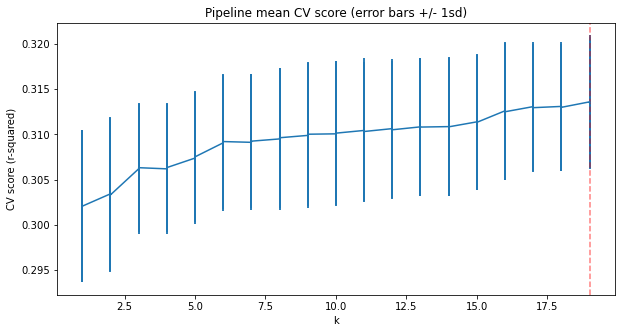

In [69]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

Here we see that while continuing to add features improves the score of the model, we don't see much better performance beyond using just two features. In this case, the adjusted R^2 may be a better way to score the models, since it penalizes the addition of more features to the model.

In [70]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [71]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train_subsample_lr.columns[selected]
pd.Series(list(coefs[0]), index=features).sort_values(ascending=False)

square_feet           199.492475
precip_depth_1_hr      16.683666
year_built             16.318013
wind_direction         14.085223
cloud_coverage         13.190633
cos_season              5.834014
sin_dayofweek           5.504321
dew_temperature         3.877932
cos_day                 0.295860
sin_day                -2.574647
sin_season             -3.686897
sea_level_pressure     -4.440066
cos_dayofweek          -7.631675
sin_hour               -9.052045
cos_month             -14.238088
cos_hour              -15.117446
wind_speed            -15.530832
sin_month             -15.969280
air_temperature       -25.150823
dtype: float64

Here it seems the most important feature is the size of the building. The next most important feature is the air_temperature, which has a negative coefficient.

#### 4.6.2.5 Measure Accuracy<a id='4.6.2.5_Measure_Accuracy'></a>

Here we measure the accuracy of the model by calculating the mean absolute error and root mean squared error for the training set and the test set.

In [76]:
mean_absolute_error(y_train_subsample_lr, y_tr_pred), mean_absolute_error(y_test_subsample_lr, y_test_pred)

(129.06110936366244, 129.67429517968833)

In [77]:
y_tr_pred = lr_grid_cv.predict(X_train_subsample_lr)
y_test_pred = lr_grid_cv.predict(X_test_subsample_lr)
(mean_squared_error(y_train_subsample_lr, y_tr_pred))**(1/2), (mean_squared_error(y_test_subsample_lr, y_test_pred))**(1/2)

(304.1959552417435, 307.3233262914149)

### 4.7.3 Random Forest Regression Model<a id='4.6.3_Random_Forest_Regression_Model'></a>

#### 4.7.3.1 Make Pipeline<a id='4.6.3.1_Make_Pipeline'></a>

I first make a pipeline that puts together the main steps for the machine learning workflow.
1. Impute remaining missing data with either the mean or median of each feature
2. Keep the data as is, or standardize it such that each feature has a mean of 0 and a variance of 1.
3. Use 1000 trees
4. Train the model

In [72]:
pipe=make_pipeline(SimpleImputer(),
    StandardScaler(),
    RandomForestRegressor(n_estimators=1000,random_state=47))

C:\Users\melis\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(n_estimators=1000,
                                                              random_state=47))]),
             n_jobs=-1,
             param_grid={'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

#### 4.6.2.2 Define Parameters to Tune<a id='4.6.2.2_Define_Parameters_to_Tune'></a>

In [ ]:
grid_params={'standardscaler':[StandardScaler(),None],
            'simpleimputer__strategy':['mean','median']}

#### 4.6.2.3 Parameter Tuning Using GridSearchCV<a id='4.6.2.3_Parameter_Tuning_Using_GridSearchCV'></a>

Here, I will use GridSearchCV to assess the models produced from using different parameters, and choose the parameters that give the best performance. I will use 3 cross-validation folds for this step.

In [ ]:
rf_grid_cv= GridSearchCV(pipe,param_grid=grid_params, cv=3, n_jobs=-1)
rf_grid_cv.fit(X_train_subsample_rf,y_train_subsample_rf)

#### 4.6.2.4 Obtain Scores<a id='4.6.2.3_Obtain_Scores'></a>

The best parameters are using the median to impute missing data and standardizing the features.

In [73]:
rf_grid_cv.best_params_

{'simpleimputer__strategy': 'median', 'standardscaler': StandardScaler()}

As with the linear regression model, the random forest regression model finds that the most important feature is the size of the building in square_feet.

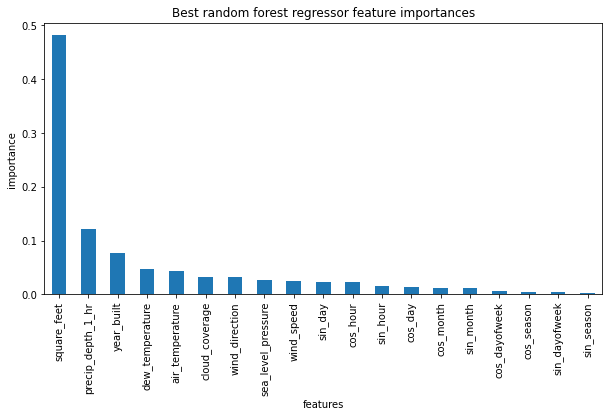

In [74]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train_subsample_rf.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [75]:
score_mean = rf_grid_cv.cv_results_['mean_test_score']
score_std = rf_grid_cv.cv_results_['std_test_score']
print(score_mean,score_std)

[0.60838989 0.60834942 0.61325696 0.61184039] [0.04066921 0.04091884 0.04002831 0.03993219]


#### 4.7.2.5 Measure Accuracy<a id='4.7.2.5_Measure_Accuracy'></a>

The mean absolute error for this model is ~100 kWh lower for the training set, and ~50 kWh lower for the testing set compared to the linear regression model. 

The root mean squared error is ~220 kWh lower for the training set, and ~120 kWh lower for the testing set.

In [34]:
mean_absolute_error(y_train_subsample_rf, y_tr_pred), mean_absolute_error(y_test_subsample_rf, y_test_pred)

(30.038378717800036, 79.16689877607996)

In [33]:
y_tr_pred = rf_grid_cv.predict(X_train_subsample_rf)
y_test_pred = rf_grid_cv.predict(X_test_subsample_rf)
(mean_squared_error(y_train_subsample_rf, y_tr_pred))**(1/2), (mean_squared_error(y_test_subsample_rf, y_test_pred))**(1/2)

(78.63987282887916, 185.9373728972383)

### 4.7.4 Ridge Regression Model<a id='4.7.4_Ridge_Regression_Model'></a>

#### 4.7.3.1 Make Pipeline<a id='4.6.3.1_Make_Pipeline'></a>

In [78]:
pipe=make_pipeline(SimpleImputer(),
    StandardScaler(),
    Ridge(normalize=True))

#### 4.7.2.2 Define Parameters to Tune<a id='4.7.2.2_Define_Parameters_to_Tune'></a>

In [79]:
alphas = [1e-3, 1e-2, 1e-1, 1]
grid_params={'standardscaler':[StandardScaler(),None],
            'simpleimputer__strategy':['mean','median'],
            'ridge__alpha': alphas}

#### 4.7.2.3 Parameter Tuning Using GridSearchCV<a id='4.7.2.3_Parameter_Tuning_Using_GridSearchCV'></a>

In [80]:
rdg_grid_cv= GridSearchCV(pipe,param_grid=grid_params, cv=3, n_jobs=-1)
rdg_grid_cv.fit(X_train_subsample_lr,y_train_subsample_lr)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('ridge', Ridge(normalize=True))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [81]:
rdg_grid_cv.best_params_

{'ridge__alpha': 0.001,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

In [83]:
score_mean = rdg_grid_cv.cv_results_['mean_test_score']
score_std = rdg_grid_cv.cv_results_['std_test_score']
print(score_mean)

[0.31361088 0.31361088 0.31349122 0.31349122 0.31358807 0.31358807
 0.31346845 0.31346845 0.31101084 0.31101084 0.3108981  0.3108981
 0.23620298 0.23620298 0.23624273 0.23624273]


In [84]:
y_tr_pred = rdg_grid_cv.predict(X_train_subsample_lr)
y_test_pred = rdg_grid_cv.predict(X_test_subsample_lr)
(mean_squared_error(y_train_subsample_lr, y_tr_pred))**(1/2), (mean_squared_error(y_test_subsample_lr, y_test_pred))**(1/2)

(304.19603394325156, 307.32722461434923)

In [85]:
mean_absolute_error(y_train_subsample_lr, y_tr_pred), mean_absolute_error(y_test_subsample_lr, y_test_pred)

(128.0042393311223, 128.5215584063653)

### 4.8 Try best model on validation data

In [86]:
val_data=pd.read_csv('../data/processed/electricity/validation_data.csv').drop('Unnamed: 0',axis=1)
val_data['timestamp']=pd.to_datetime(val_data['timestamp'],format='%Y-%m-%d %H:%M:%S')

In [87]:
timestamp=val_data['timestamp']

In [88]:
val_data=val_data.drop(['building_id','meter','timestamp','month','day',
                        'dayofweek','hour','site_id','primary_use','consumption_per_square_feet',
                        'season','floor_count'],axis=1)

In [89]:
X=val_data.drop(columns='meter_reading')
y=val_data.meter_reading

In [90]:
y_val_pred=rf_grid_cv.predict(X)

In [91]:
(mean_squared_error(y, y_val_pred))**(1/2)

238.7844276624935

In [92]:
mean_absolute_error(y, y_val_pred)

232.5843341226948

In [93]:
pd.Series(y_val_pred)

0       144.041333
1       143.444147
2       144.674966
3       152.631042
4       169.311459
           ...    
8768    229.526612
8769    248.772280
8770    232.533050
8771    236.183695
8772    225.774751
Length: 8773, dtype: float64

In [94]:
y

0       416.169
1       408.616
2       412.072
3       393.053
4       404.519
         ...   
8768    456.460
8769    455.198
8770    466.479
8771    471.751
8772    461.110
Name: meter_reading, Length: 8773, dtype: float64

In [95]:
predictions=pd.concat([timestamp,pd.DataFrame(y_val_pred, columns=['meter_reading'])],axis=1)

In [96]:
predictions

,timestamp,meter_reading
0,2016-01-01 00:00:00,144.041333
1,2016-01-01 01:00:00,143.444147
2,2016-01-01 02:00:00,144.674966
3,2016-01-01 03:00:00,152.631042
4,2016-01-01 04:00:00,169.311459
...,...,...
8768,2016-12-31 14:00:00,229.526612
8769,2016-12-31 15:00:00,248.772280
8770,2016-12-31 16:00:00,232.533050
8771,2016-12-31 17:00:00,236.183695


In [97]:
old=pd.concat([timestamp,y],axis=1)

In [98]:
old

,timestamp,meter_reading
0,2016-01-01 00:00:00,416.169
1,2016-01-01 01:00:00,408.616
2,2016-01-01 02:00:00,412.072
3,2016-01-01 03:00:00,393.053
4,2016-01-01 04:00:00,404.519
...,...,...
8768,2016-12-31 14:00:00,456.460
8769,2016-12-31 15:00:00,455.198
8770,2016-12-31 16:00:00,466.479
8771,2016-12-31 17:00:00,471.751


In [99]:
old['moving_avg'] = old['meter_reading'].interpolate('index').rolling(720).mean()

In [100]:
predictions['moving_avg'] = predictions['meter_reading'].interpolate('index').rolling(720).mean()

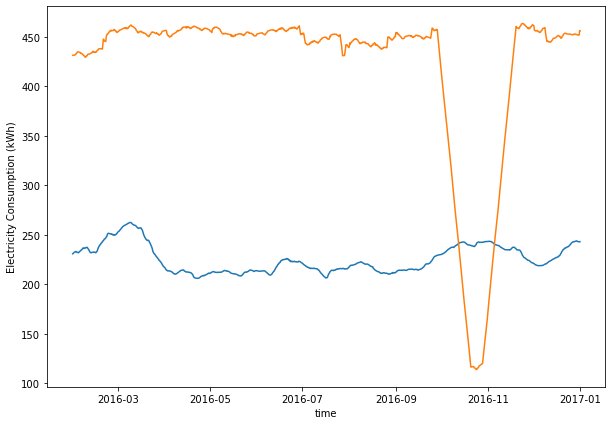

In [101]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(timestamp,predictions['moving_avg'])
ax.plot(timestamp,old['moving_avg'])
ax.set_xlabel('time')
ax.set_ylabel('Electricity Consumption (kWh)')
plt.show()